In [1]:
# このnotebookの存在するディレクトリのパス(必要に応じて変更してください)
path = "/root/userspace/materials_1114/2_3_mini_project/"

In [2]:
import numpy as np
import pandas as pd

def load_dataset():
    
    # 学習データ
    x_train = np.load(path+'data/x_train.npy')
    y_train = np.load(path+'data/y_train.npy')

    # テストデータ
    x_test = np.load(path+'data/x_test.npy')
    
    x_train = x_train / 255.
    x_test = x_test / 255.
    
    y_train = np.eye(10)[y_train]
    
    return (x_train, x_test, y_train)

x_train, x_test, y_train = load_dataset()

In [3]:
from sklearn.model_selection import train_test_split
#訓練データをtrainとvalidに分割する
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)

In [ ]:
#学習済みモデルをFineTuningして予測を行う
#3つのモデルを作成し、ファイルに書き出しておく

In [7]:
#InceptionV3をFineTuning（転移学習とは異なる）して分類を行う
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Flatten,Dense,GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

N_CATEGORIES = 10
IMAGE_SIZE = 256
BATCH_SIZE = 16

input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
base_model = InceptionV3(include_top=False,weights='imagenet',input_tensor=input_tensor)
early_stopping = EarlyStopping(patience=5, verbose=1)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions = Dense(N_CATEGORIES,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)

#for layer in ResNet50.layers:
#    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3,momentum=0.9),
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   rotation_range=20)

#train_generator = train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE,shuffle=True)

#history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, validation_split=0.1)
hist = model.fit_generator(train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE,shuffle=True),
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
                           epochs=30, 
                           validation_data=(x_valid, y_valid),
                           callbacks=[early_stopping])

Epoch 1/30
479/479 [==============================] - 161s 336ms/step - loss: 0.7596 - acc: 0.7665 - val_loss: 0.3114 - val_acc: 0.9118
Epoch 2/30
479/479 [==============================] - 152s 318ms/step - loss: 0.3086 - acc: 0.9080 - val_loss: 0.2940 - val_acc: 0.9376
Epoch 3/30
479/479 [==============================] - 152s 317ms/step - loss: 0.2126 - acc: 0.9349 - val_loss: 0.1977 - val_acc: 0.9400
Epoch 4/30
479/479 [==============================] - 152s 317ms/step - loss: 0.1651 - acc: 0.9478 - val_loss: 0.3308 - val_acc: 0.9118
Epoch 5/30
479/479 [==============================] - 152s 317ms/step - loss: 0.1429 - acc: 0.9563 - val_loss: 0.2084 - val_acc: 0.9412
Epoch 6/30
479/479 [==============================] - 152s 318ms/step - loss: 0.1147 - acc: 0.9597 - val_loss: 0.2053 - val_acc: 0.9518
Epoch 7/30
479/479 [==============================] - 152s 318ms/step - loss: 0.1033 - acc: 0.9671 - val_loss: 0.2697 - val_acc: 0.9447
Epoch 8/30
479/479 [============================

In [10]:
#モデルを書き出し
import os.path
f_model = '/root/userspace/materials_1114/2_3_mini_project/'
print('save the architecture of a model')
json_string = model.to_json()
open(os.path.join(f_model,'cnn_incepv3_096_model.json'), 'w').write(json_string)
yaml_string = model.to_yaml()
open(os.path.join(f_model,'cnn_incepv3_096_model.yaml'), 'w').write(yaml_string)
print('save weights')
model.save_weights(os.path.join(f_model,'cnn_incepv3_096_model_weights.hdf5'))

save the architecture of a model
save weights


In [6]:
#ResNetをFineTuning（転移学習とは異なる）して分類を行う
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Flatten,Dense,GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

N_CATEGORIES = 10
IMAGE_SIZE = 256
BATCH_SIZE = 16

input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
#ResNet50 = ResNet50(include_top=False,weights='imagenet',input_tensor=input_tensor)
base_model = ResNet50(include_top=False,weights='imagenet',input_tensor=input_tensor)
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
early_stopping = EarlyStopping(patience=3, verbose=1)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions = Dense(N_CATEGORIES,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)

#top_model = Sequential()
#top_model.add(Flatten(input_shape=ResNet50.output_shape[1:]))
#top_model.add(Dense(10,activation='softmax'))
#model = Model(inputs=ResNet50.input,outputs=top_model(ResNet50.output))

#for layer in ResNet50.layers:
#    layer.trainable = False

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3,momentum=0.9),
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   rotation_range=20)

#train_generator = train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE,shuffle=True)

#history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=5, validation_split=0.1)
hist = model.fit_generator(train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE,shuffle=True),
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
                           epochs=30, 
                           validation_data=(x_valid, y_valid),
                           callbacks=[early_stopping])


Instructions for updating:
Use tf.cast instead.
Epoch 1/30
479/479 [==============================] - 265s 553ms/step - loss: 0.6209 - acc: 0.7999 - val_loss: 2.5402 - val_acc: 0.1588
Epoch 2/30
479/479 [==============================] - 207s 432ms/step - loss: 0.2430 - acc: 0.9235 - val_loss: 0.3983 - val_acc: 0.8706
Epoch 3/30
479/479 [==============================] - 207s 432ms/step - loss: 0.1754 - acc: 0.9452 - val_loss: 0.2378 - val_acc: 0.9353
Epoch 4/30
479/479 [==============================] - 207s 432ms/step - loss: 0.1452 - acc: 0.9566 - val_loss: 0.3128 - val_acc: 0.9235
Epoch 5/30
479/479 [==============================] - 207s 432ms/step - loss: 0.1024 - acc: 0.9681 - val_loss: 0.2567 - val_acc: 0.9259
Epoch 6/30
479/479 [==============================] - 207s 432ms/step - loss: 0.0866 - acc: 0.9728 - val_loss: 0.2311 - val_acc: 0.9424
Epoch 7/30
479/479 [==============================] - 207s 432ms/step - loss: 0.0582 - acc: 0.9809 - val_loss: 0.2221 - val_acc: 0.9494


In [8]:
#モデルを書き出し
import os.path
f_model = '/root/userspace/materials_1114/2_3_mini_project/'
print('save the architecture of a model')
json_string = model.to_json()
open(os.path.join(f_model,'cnn_resnet_094_model.json'), 'w').write(json_string)
yaml_string = model.to_yaml()
open(os.path.join(f_model,'cnn_resnet_094_model.yaml'), 'w').write(yaml_string)
print('save weights')
model.save_weights(os.path.join(f_model,'cnn_resnet_094_model_weights.hdf5'))

save the architecture of a model
save weights


In [4]:
#VGG16をFineTuning（転移学習とは異なる）して分類を行う
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,GlobalAveragePooling2D,Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

N_CATEGORIES = 10
IMAGE_SIZE = 256
BATCH_SIZE = 16
NUM_TRAINING = 7650
NUM_VALIDATION = 850
input_tensor = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3))
base_model = VGG16(weights='imagenet',include_top=False,input_tensor=input_tensor)
#x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1)
early_stopping = EarlyStopping(patience=3, verbose=1)

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)
predictions = Dense(N_CATEGORIES,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=predictions)

#for layer in base_model.layers:
#    layer.trainable = False
#for layer in base_model.layers[:15]:
#    layer.trainable = False

model.compile(optimizer=SGD(lr=0.0001,momentum=0.9),loss='categorical_crossentropy',metrics=['accuracy'])

#model.summary()

train_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=10)

#train_generator = train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE,shuffle=True)

valid_datagen = ImageDataGenerator(shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=10)

#valid_generator = valid_datagen.flow(x_valid, y_valid,batch_size=BATCH_SIZE,shuffle=True)

hist = model.fit_generator(train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE,shuffle=True),
                    steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
                           epochs=30, 
                           validation_data=valid_datagen.flow(x_valid, y_valid,batch_size=BATCH_SIZE,shuffle=True),
                           validation_steps=y_train.shape[0]//BATCH_SIZE,
                           callbacks=[early_stopping])


Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
957/957 [==============================] - 293s 306ms/step - loss: 1.7054 - acc: 0.4064 - val_loss: 1.0720 - val_acc: 0.6400
Epoch 2/30
957/957 [==============================] - 250s 261ms/step - loss: 0.9033 - acc: 0.7076 - val_loss: 0.6987 - val_acc: 0.7894
Epoch 3/30
957/957 [==============================] - 248s 260ms/step - loss: 0.6787 - acc: 0.7795 - val_loss: 0.7472 - val_acc: 0.7706
Epoch 4/30
957/957 [==============================] - 249s 260ms/step - loss: 0.5633 - acc: 0.8182 - val_loss: 0.4592 - val_acc: 0.8612
Epoch 5/30
957/957 [==============================] - 248s 259ms/step - loss: 0.4620 - acc: 0.8562 - val_loss: 0.4786 - val_acc: 0.8541
Epoch 6/30
957/957 [==============================] - 249s 260ms/step - loss: 0.4159 - acc: 0.8675 - val_loss: 0.4488 - val_acc: 0.8635

In [5]:
#モデルを書き出し
import os.path
f_model = '/root/userspace/materials_1114/2_3_mini_project/'
print('save the architecture of a model')
json_string = model.to_json()
open(os.path.join(f_model,'cnn_vgg16_xxx_model.json'), 'w').write(json_string)
yaml_string = model.to_yaml()
open(os.path.join(f_model,'cnn_vgg16_xxx_model.yaml'), 'w').write(yaml_string)
print('save weights')
model.save_weights(os.path.join(f_model,'cnn_vgg16_xxx_model_weights.hdf5'))



save the architecture of a model
save weights


In [4]:
#モデルのロード　テスト
import os.path
from tensorflow.keras.models import model_from_json
from tensorflow.keras import optimizers

f_model = '/root/userspace/materials_1114/2_3_mini_project/'
model_filename = 'cnn_incepv3_096_model.json'
weights_filename = 'cnn_incepv3_096_model_weights.hdf5'

json_string = open(os.path.join(f_model, model_filename)).read()
model = model_from_json(json_string)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3,momentum=0.9),
              metrics=['accuracy'])
model.load_weights(os.path.join(f_model,weights_filename))    

Instructions for updating:
Colocations handled automatically by placer.


In [5]:
#予測結果書き出し　テスト
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, 1)
y_pred_index =y_pred

submission = pd.Series(y_pred, name='label')
submission.to_csv(path+'submission_incepv3_096.csv', header=True, index_label='id')

In [30]:
#モデルのロード　3つの作成済みモデルをロードする
import os.path
from tensorflow.keras.models import model_from_json
from tensorflow.keras import optimizers

f_model = '/root/userspace/materials_1114/2_3_mini_project/'
model_filename = 'cnn_incepv3_096_model.json'
weights_filename = 'cnn_incepv3_096_model_weights.hdf5'

json_string = open(os.path.join(f_model, model_filename)).read()
model = model_from_json(json_string)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3,momentum=0.9),
              metrics=['accuracy'])
model.load_weights(os.path.join(f_model,weights_filename))    

models = []
models.append(model)

f_model = '/root/userspace/materials_1114/2_3_mini_project/'
model_filename = 'cnn_resnet_094_model.json'
weights_filename = 'cnn_resnet_094_model_weights.hdf5'

json_string = open(os.path.join(f_model, model_filename)).read()
model = model_from_json(json_string)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3,momentum=0.9),
              metrics=['accuracy'])
model.load_weights(os.path.join(f_model,weights_filename))    

models.append(model)

f_model = '/root/userspace/materials_1114/2_3_mini_project/'
model_filename = 'cnn_vgg16_093_model.json'
weights_filename = 'cnn_vgg16_093_model_weights.hdf5'

json_string = open(os.path.join(f_model, model_filename)).read()
model = model_from_json(json_string)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-3,momentum=0.9),
              metrics=['accuracy'])
model.load_weights(os.path.join(f_model,weights_filename))    

models.append(model)


Instructions for updating:
Colocations handled automatically by placer.


In [31]:
#アンサンブル（ソフト）　確率でモデルの予測結果をブレンドする
#validationのaccuracyがよかった1つ目のモデルを2倍の割合でブレンドする
#2倍の根拠は特にない
preds_sum = None
for model in models:
    if preds_sum is None:
        preds_sum = model.predict(x_test)*2
    else:
        preds_sum += model.predict(x_test)
probs = preds_sum / len(models)
y_pred = np.argmax(probs, axis=-1)

submission = pd.Series(y_pred, name='label')
submission.to_csv(path+'submission_ensembling_2.csv', header=True, index_label='id')

In [ ]:
#ここから分類対象の画像を確認するためのコード

In [4]:
#画像を確認する
import numpy as np
import pandas as pd
from PIL import Image

def load_dataset():
    
    # 学習データ
    x_train_orig = np.load(path+'data/x_train.npy')
    y_train_orig = np.load(path+'data/y_train.npy')

    # テストデータ
    x_test_orig = np.load(path+'data/x_test.npy')
    
    #x_train = x_train / 255.
    #x_test = x_test / 255.
    
    y_train = np.eye(10)[y_train_orig]
    
    return (x_train_orig, x_test_orig, y_train)

x_train_orig, x_test_orig, y_train = load_dataset()

In [7]:
import cv2
from IPython.display import Image
#print(len(x_test_orig))
#print(x_train_orig.shape)
#print(x_train_orig[0].dtype)
#im_bgr = x_test_orig[10]
#im_rgb = im_bgr[:, :, [2, 1, 0]]
#cv2.imwrite("/root/userspace/materials_1114/2_3_mini_project/test1.jpg", im_rgb)
#print(x_test_orig.shape)
#Image("/root/userspace/materials_1114/2_3_mini_project/test1.jpg")
#Image("/root/userspace/materials_1114/2_3_mini_project/test1.jpg")
image_path_list = []
max_image_count = 100
image_count = 0
y_train_index = np.argmax(y_train, 1)

for i in range(len(y_pred_index+1)):
#for i in range(len(y_train_index)):
    if y_pred_index[i] == 1:
#    if y_train_index[i] == 2:
        im_bgr = x_test_orig[i]
#        im_bgr = x_train_orig[i]
        im_rgb = im_bgr[:, :, [2, 1, 0]]
        cv2.imwrite("/root/userspace/materials_1114/2_3_mini_project/image/test"+str(image_count)+".jpg", im_rgb)
        image_path_list.append("/root/userspace/materials_1114/2_3_mini_project/image/test"+str(image_count)+".jpg")
        image_count += 1
        if image_count >= max_image_count:
            break

In [ ]:
import cv2
from IPython.display import Image
image_path_list = []
max_image_count = 100
image_count = 0
y_train_index = np.argmax(y_train, 1)
start_image_count = 300
for i in range(start_image_count,start_image_count+100):
    im_bgr = x_train_orig[i]
    im_rgb = im_bgr[:, :, [2, 1, 0]]
    cv2.imwrite("/root/userspace/materials_1114/2_3_mini_project/image/test"+str(image_count)+".jpg", im_rgb)
    image_path_list.append("/root/userspace/materials_1114/2_3_mini_project/image/test"+str(image_count)+".jpg")
    image_count += 1


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

#plt.imshow(mpimg.imread(image_path_list[1]),cmap="gray")

plt.figure(figsize=(256,256))
for i,d in enumerate(image_path_list):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(d),cmap="gray")


In [ ]:
import cv2
from IPython.display import Image
im_bgr = x_train_orig[10]
im_rgb = im_bgr[:, :, [2, 1, 0]]
cv2.imwrite("/root/userspace/materials_1114/2_3_mini_project/test1.jpg", im_rgb)
Image("/root/userspace/materials_1114/2_3_mini_project/test1.jpg")

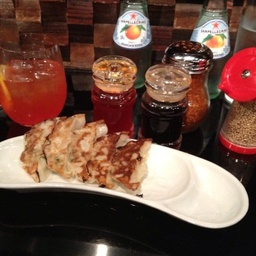

In [35]:
#0:寿司、1:ラーメン、2:ピザ、3:バーガー、4:枝豆、5:餃子、6:ピビンパ、7:マカロン、8:カキ、9:ケーキ
import cv2
from IPython.display import Image
im_bgr = x_test_orig[920]
im_rgb = im_bgr[:, :, [2, 1, 0]]
cv2.imwrite("/root/userspace/materials_1114/2_3_mini_project/test1.jpg", im_rgb)
Image("/root/userspace/materials_1114/2_3_mini_project/test1.jpg")